In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7635183553812755424
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338085172
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 15913142509761456592
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:88:00.0, compute capability: 3.7"
]


In [2]:

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

In [3]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [4]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [5]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [6]:
with open('snibc_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snibc_flux = pickle.load(filehandle)

In [7]:
with open('snic_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snic_flux = pickle.load(filehandle)

In [8]:
with open('sniilp_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniilp_flux = pickle.load(filehandle)

In [9]:
with open('sniin_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    sniin_flux = pickle.load(filehandle)

In [10]:
with open('sniip_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniip_flux = pickle.load(filehandle)

In [11]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 150)

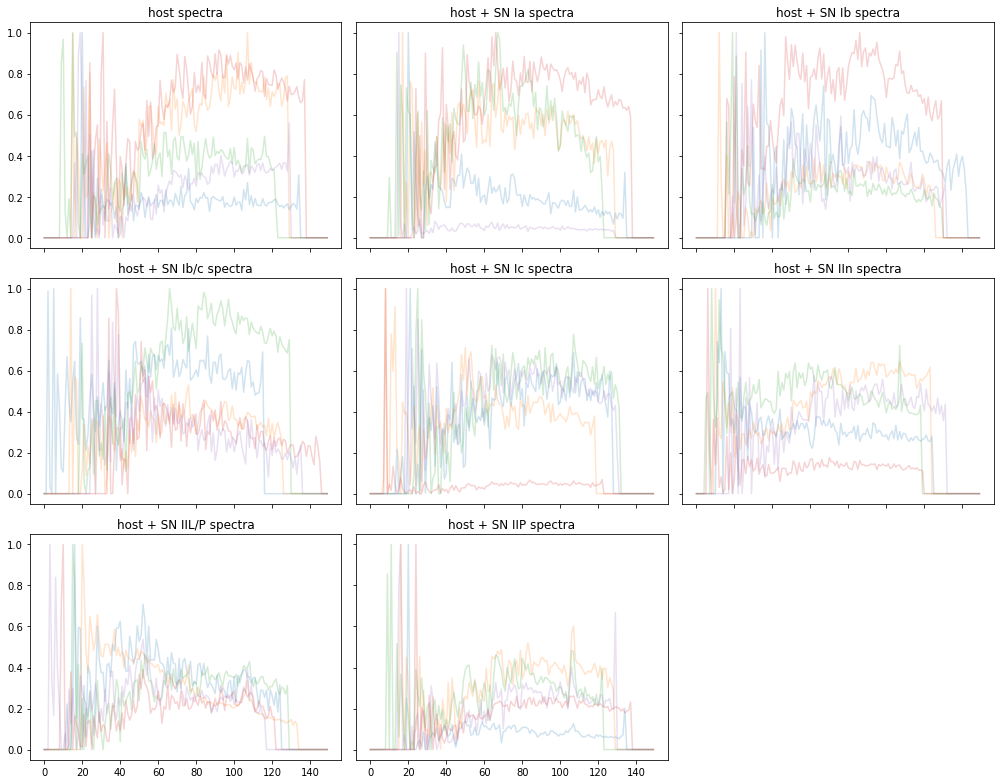

In [12]:
# PLOT
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,5):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snibc_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniin_flux[i], alpha=0.2)

    ax = axes[6]
    ax.plot(sniilp_flux[i], alpha=0.2)
    
    ax = axes[7]
    ax.plot(sniip_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ib/c spectra')
axes[4].set_title('host + SN Ic spectra')
axes[5].set_title('host + SN IIn spectra')
axes[6].set_title('host + SN IIL/P spectra')
axes[7].set_title('host + SN IIP spectra')

axes[8].axis('off')

fig.tight_layout()


x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7)
                       ]))

In [13]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM

In [14]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# Grid Search

from keras import backend as K
def generate_model(input_shape=(nbins, 1),ncat=y.shape[1], learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=1):
    """ 
    Args:
    input_shape -- shape of the input spectra
    regularization_strength -- regularization factor
    dropout -- dropout rate
    seed -- seed of initializer
    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

Using TensorFlow backend.


In [15]:
model = generate_model()
model.summary()

W0806 19:21:19.190500 47416629715840 nn_ops.py:4220] Large dropout rate: 0.7436 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 8)            48        
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 8)            32        
_________________________________________________________________
activation (Activation)      (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 16)            64    

In [16]:
import hyperopt, hyperas

from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn =generate_model,epochs = 25, batch_size = 64)
lrlist = np.logspace(-5,-1,7)
lrlist = lrlist.tolist()
ins = ((150,1),)
lr= lrlist
reg=(0.0032,)
dr = [0.1,0.2,0.4,0.6,0.8]
seed = (1,)

In [17]:
# Prepare the Grid
param_grid = dict(input_shape=ins, learning_rate=lr, reg=reg, dropout=dr, seed=seed)
type(param_grid)

dict

In [18]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [19]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=None, cv=3, verbose=2)

In [20]:
grid_result = grid.fit(x_train, y_train) # 30 epochs

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] dropout=0.1, input_shape=(150, 1), learning_rate=1e-05, reg=0.0032, seed=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 11s 276us/sample - loss: 3.5209 - acc: 0.1771
Epoch 2/25
38994/38994 [==============================] - 6s 155us/sample - loss: 3.3449 - acc: 0.2376
Epoch 3/25
38994/38994 [==============================] - 6s 155us/sample - loss: 3.2289 - acc: 0.2797
Epoch 4/25
38994/38994 [==============================] - 6s 155us/sample - loss: 3.1340 - acc: 0.3115
Epoch 5/25
38994/38994 [==============================] - 6s 153us/sample - loss: 3.0529 - acc: 0.3337
Epoch 6/25
38994/38994 [==============================] - 6s 155us/sample - loss: 2.9757 - acc: 0.3578
Epoch 7/25
38994/38994 [==============================] - 6s 153us/sample - loss: 2.9029 - acc: 0.3772
Epoch 8/25
38994/38994 [==============================] - 6s 155us/sample - loss: 2.8367 - acc: 0.3960
Epoch 9/25
38994/38994 [==============================] - 6s 154us/sample - loss: 2.7709 - acc: 0.4128
Epoch 10/25
38994/38994 [========================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 7s 167us/sample - loss: 3.5465 - acc: 0.1695
Epoch 2/25
38995/38995 [==============================] - 6s 153us/sample - loss: 3.3549 - acc: 0.2339
Epoch 3/25
38995/38995 [==============================] - 6s 156us/sample - loss: 3.2421 - acc: 0.2713
Epoch 4/25
38995/38995 [==============================] - 6s 154us/sample - loss: 3.1464 - acc: 0.3027
Epoch 5/25
38995/38995 [==============================] - 6s 154us/sample - loss: 3.0587 - acc: 0.3314
Epoch 6/25
38995/38995 [==============================] - 6s 154us/sample - loss: 2.9789 - acc: 0.3540
Epoch 7/25
38995/38995 [==============================] - 6s 154us/sample - loss: 2.9018 - acc: 0.3793
Epoch 8/25
38995/38995 [==============================] - 6s 155us/sample - loss: 2.8315 - acc: 0.3954
Epoch 9/25
38995/38995 [==============================] - 6s 154us/sample - loss: 2.7648 - acc: 0.4134
Epoch 10/25
38995/38995 [=========================

38994/38994 [==============================] - 6s 154us/sample - loss: 1.3824 - acc: 0.6739
Epoch 25/25
19498/19498 [==============================] - 1s 59us/sample - loss: 1.4170 - acc: 0.6572
[CV]  dropout=0.1, input_shape=(150, 1), learning_rate=4.641588833612782e-05, reg=0.0032, seed=1, total= 2.6min
[CV] dropout=0.1, input_shape=(150, 1), learning_rate=4.641588833612782e-05, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 7s 169us/sample - loss: 3.3401 - acc: 0.2395
Epoch 2/25
38995/38995 [==============================] - 6s 155us/sample - loss: 2.9244 - acc: 0.3729
Epoch 3/25
38995/38995 [==============================] - 6s 155us/sample - loss: 2.6521 - acc: 0.4471
Epoch 4/25
38995/38995 [==============================] - 6s 155us/sample - loss: 2.4551 - acc: 0.4942
Epoch 5/25
38995/38995 [==============================] - 6s 155us/sample - loss: 2.3105 - acc: 0.5267
Epoch 6/25
38995/38995 [==============================] - 

38994/38994 [==============================] - 6s 160us/sample - loss: 0.9955 - acc: 0.7312
Epoch 19/25
38994/38994 [==============================] - 6s 157us/sample - loss: 0.9851 - acc: 0.7345
Epoch 20/25
38994/38994 [==============================] - 6s 156us/sample - loss: 0.9768 - acc: 0.7346
Epoch 21/25
38994/38994 [==============================] - 6s 156us/sample - loss: 0.9687 - acc: 0.7383
Epoch 22/25
38994/38994 [==============================] - 6s 156us/sample - loss: 0.9620 - acc: 0.7391
Epoch 23/25
38994/38994 [==============================] - 6s 157us/sample - loss: 0.9508 - acc: 0.7433
Epoch 24/25
38994/38994 [==============================] - 6s 157us/sample - loss: 0.9432 - acc: 0.7453
Epoch 25/25
19498/19498 [==============================] - 1s 63us/sample - loss: 1.1048 - acc: 0.6857
[CV]  dropout=0.1, input_shape=(150, 1), learning_rate=0.00021544346900318823, reg=0.0032, seed=1, total= 2.6min
[CV] dropout=0.1, input_shape=(150, 1), learning_rate=0.000215443469

Epoch 13/25
38994/38994 [==============================] - 6s 158us/sample - loss: 1.0204 - acc: 0.7034
Epoch 14/25
38994/38994 [==============================] - 6s 157us/sample - loss: 1.0215 - acc: 0.7049
Epoch 15/25
38994/38994 [==============================] - 6s 157us/sample - loss: 1.0121 - acc: 0.7108
Epoch 16/25
38994/38994 [==============================] - 6s 157us/sample - loss: 1.0081 - acc: 0.7108
Epoch 17/25
38994/38994 [==============================] - 6s 157us/sample - loss: 1.0063 - acc: 0.7094
Epoch 18/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.0022 - acc: 0.7115
Epoch 19/25
38994/38994 [==============================] - 6s 157us/sample - loss: 1.0009 - acc: 0.7128
Epoch 20/25
38994/38994 [==============================] - 6s 157us/sample - loss: 0.9977 - acc: 0.7129
Epoch 21/25
38994/38994 [==============================] - 6s 158us/sample - loss: 0.9895 - acc: 0.7161
Epoch 22/25
38994/38994 [==============================] - 6s 15

38994/38994 [==============================] - 6s 160us/sample - loss: 1.2364 - acc: 0.6370
Epoch 9/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.2224 - acc: 0.6435
Epoch 10/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.2191 - acc: 0.6413
Epoch 11/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.2136 - acc: 0.6424
Epoch 12/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.2065 - acc: 0.6446
Epoch 13/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.1993 - acc: 0.6464
Epoch 14/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.1983 - acc: 0.6472
Epoch 15/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.1985 - acc: 0.6438
Epoch 16/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.2016 - acc: 0.6459
Epoch 17/25
38994/38994 [==============================] - 6s 162us/sample - 

38994/38994 [==============================] - 6s 163us/sample - loss: 1.6592 - acc: 0.4531
Epoch 3/25
38994/38994 [==============================] - 6s 161us/sample - loss: 1.5996 - acc: 0.4720
Epoch 4/25
38994/38994 [==============================] - 6s 161us/sample - loss: 1.5749 - acc: 0.4840
Epoch 5/25
38994/38994 [==============================] - 6s 161us/sample - loss: 1.5606 - acc: 0.4890
Epoch 6/25
38994/38994 [==============================] - 6s 161us/sample - loss: 1.5464 - acc: 0.4952
Epoch 7/25
38994/38994 [==============================] - 6s 165us/sample - loss: 1.5424 - acc: 0.4972
Epoch 8/25
38994/38994 [==============================] - 6s 161us/sample - loss: 1.5411 - acc: 0.4967
Epoch 9/25
38994/38994 [==============================] - 6s 161us/sample - loss: 1.5304 - acc: 0.5006
Epoch 10/25
38994/38994 [==============================] - 6s 161us/sample - loss: 1.5332 - acc: 0.4986
Epoch 11/25
38994/38994 [==============================] - 6s 162us/sample - loss: 

Epoch 25/25
19497/19497 [==============================] - 2s 78us/sample - loss: 1.7960 - acc: 0.3649
[CV]  dropout=0.1, input_shape=(150, 1), learning_rate=0.021544346900318822, reg=0.0032, seed=1, total= 2.8min
[CV] dropout=0.1, input_shape=(150, 1), learning_rate=0.1, reg=0.0032, seed=1 
Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 7s 182us/sample - loss: 4.6797 - acc: 0.1246
Epoch 2/25
38994/38994 [==============================] - 6s 161us/sample - loss: 2.0968 - acc: 0.1267
Epoch 3/25
38994/38994 [==============================] - 6s 162us/sample - loss: 2.0878 - acc: 0.1233
Epoch 4/25
38994/38994 [==============================] - 6s 162us/sample - loss: 2.0859 - acc: 0.1270
Epoch 5/25
38994/38994 [==============================] - 6s 162us/sample - loss: 2.0857 - acc: 0.1235
Epoch 6/25
38994/38994 [==============================] - 6s 162us/sample - loss: 2.0851 - acc: 0.1271
Epoch 7/25
38994/38994 [==============================] - 6s 162us

38995/38995 [==============================] - 6s 162us/sample - loss: 2.0840 - acc: 0.1265
Epoch 21/25
38995/38995 [==============================] - 6s 162us/sample - loss: 2.0860 - acc: 0.1288
Epoch 22/25
38995/38995 [==============================] - 6s 165us/sample - loss: 2.0863 - acc: 0.1257
Epoch 23/25
38995/38995 [==============================] - 6s 164us/sample - loss: 2.0860 - acc: 0.1280
Epoch 24/25
38995/38995 [==============================] - 6s 162us/sample - loss: 2.0862 - acc: 0.1280
Epoch 25/25
19497/19497 [==============================] - 2s 81us/sample - loss: 2.0838 - acc: 0.1256
[CV]  dropout=0.1, input_shape=(150, 1), learning_rate=0.1, reg=0.0032, seed=1, total= 2.8min
[CV] dropout=0.2, input_shape=(150, 1), learning_rate=1e-05, reg=0.0032, seed=1 
Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 7s 184us/sample - loss: 3.6041 - acc: 0.1473
Epoch 2/25
38994/38994 [==============================] - 6s 162us/sample - loss: 3.4128

38995/38995 [==============================] - 6s 162us/sample - loss: 2.5311 - acc: 0.4792
Epoch 16/25
38995/38995 [==============================] - 6s 162us/sample - loss: 2.4974 - acc: 0.4887
Epoch 17/25
38995/38995 [==============================] - 6s 162us/sample - loss: 2.4586 - acc: 0.4966
Epoch 18/25
38995/38995 [==============================] - 6s 163us/sample - loss: 2.4278 - acc: 0.5012
Epoch 19/25
38995/38995 [==============================] - 6s 162us/sample - loss: 2.3937 - acc: 0.5098
Epoch 20/25
38995/38995 [==============================] - 6s 162us/sample - loss: 2.3651 - acc: 0.5169
Epoch 21/25
38995/38995 [==============================] - 6s 162us/sample - loss: 2.3356 - acc: 0.5236
Epoch 22/25
38995/38995 [==============================] - 6s 162us/sample - loss: 2.3091 - acc: 0.5295
Epoch 23/25
38995/38995 [==============================] - 6s 163us/sample - loss: 2.2837 - acc: 0.5317
Epoch 24/25
38995/38995 [==============================] - 6s 162us/sample -

Epoch 10/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.8735 - acc: 0.6006
Epoch 11/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.8181 - acc: 0.6096
Epoch 12/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.7672 - acc: 0.6171
Epoch 13/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.7175 - acc: 0.6259
Epoch 14/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.6768 - acc: 0.6311
Epoch 15/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.6384 - acc: 0.6376
Epoch 16/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.6006 - acc: 0.6415
Epoch 17/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.5653 - acc: 0.6455
Epoch 18/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.5356 - acc: 0.6500
Epoch 19/25
38995/38995 [==============================] - 6s 16

38995/38995 [==============================] - 6s 165us/sample - loss: 1.6136 - acc: 0.6262
Epoch 5/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.4811 - acc: 0.6439
Epoch 6/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.3829 - acc: 0.6574
Epoch 7/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.3113 - acc: 0.6682
Epoch 8/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.2568 - acc: 0.6742
Epoch 9/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.2062 - acc: 0.6839
Epoch 10/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.1740 - acc: 0.6893
Epoch 11/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.1410 - acc: 0.6951
Epoch 12/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.1165 - acc: 0.6998
Epoch 13/25
38995/38995 [==============================] - 6s 165us/sample - loss

Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 7s 192us/sample - loss: 2.0924 - acc: 0.4888
Epoch 2/25
38995/38995 [==============================] - 6s 165us/sample - loss: 1.3924 - acc: 0.6173
Epoch 3/25
38995/38995 [==============================] - 6s 165us/sample - loss: 1.2347 - acc: 0.6516
Epoch 4/25
38995/38995 [==============================] - 6s 166us/sample - loss: 1.1771 - acc: 0.6598
Epoch 5/25
38995/38995 [==============================] - 6s 165us/sample - loss: 1.1357 - acc: 0.6695
Epoch 6/25
38995/38995 [==============================] - 6s 165us/sample - loss: 1.1113 - acc: 0.6760
Epoch 7/25
38995/38995 [==============================] - 6s 166us/sample - loss: 1.0983 - acc: 0.6820
Epoch 8/25
38995/38995 [==============================] - 6s 165us/sample - loss: 1.0890 - acc: 0.6859
Epoch 9/25
38995/38995 [==============================] - 6s 165us/sample - loss: 1.0738 - acc: 0.6885
Epoch 10/25
38995/38995 [=========================

38995/38995 [==============================] - 7s 178us/sample - loss: 1.2175 - acc: 0.6416
Epoch 24/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.2052 - acc: 0.6445
Epoch 25/25
19497/19497 [==============================] - 2s 102us/sample - loss: 1.3087 - acc: 0.6029
[CV]  dropout=0.2, input_shape=(150, 1), learning_rate=0.004641588833612777, reg=0.0032, seed=1, total= 3.0min
[CV] dropout=0.2, input_shape=(150, 1), learning_rate=0.004641588833612777, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 8s 195us/sample - loss: 1.7916 - acc: 0.4655
Epoch 2/25
38995/38995 [==============================] - 6s 166us/sample - loss: 1.3917 - acc: 0.5892
Epoch 3/25
38995/38995 [==============================] - 7s 167us/sample - loss: 1.3351 - acc: 0.6084
Epoch 4/25
38995/38995 [==============================] - 7s 167us/sample - loss: 1.3105 - acc: 0.6144
Epoch 5/25
38995/38995 [==============================] - 

38995/38995 [==============================] - 7s 168us/sample - loss: 1.8561 - acc: 0.2972
Epoch 18/25
38995/38995 [==============================] - 7s 169us/sample - loss: 1.8425 - acc: 0.3079
Epoch 19/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.8443 - acc: 0.3036
Epoch 20/25
38995/38995 [==============================] - 7s 169us/sample - loss: 1.8507 - acc: 0.2989
Epoch 21/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.8486 - acc: 0.2994
Epoch 22/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.8502 - acc: 0.3031
Epoch 23/25
38995/38995 [==============================] - 7s 169us/sample - loss: 1.8453 - acc: 0.3021
Epoch 24/25
38995/38995 [==============================] - 7s 169us/sample - loss: 1.8517 - acc: 0.2995
Epoch 25/25
19497/19497 [==============================] - 2s 104us/sample - loss: 2.2448 - acc: 0.1606
[CV]  dropout=0.2, input_shape=(150, 1), learning_rate=0.021544346900318822,

38995/38995 [==============================] - 7s 174us/sample - loss: 2.0868 - acc: 0.1268
Epoch 13/25
38995/38995 [==============================] - 7s 173us/sample - loss: 2.0859 - acc: 0.1282
Epoch 14/25
38995/38995 [==============================] - 7s 171us/sample - loss: 2.0862 - acc: 0.1277
Epoch 15/25
38995/38995 [==============================] - 7s 172us/sample - loss: 2.0862 - acc: 0.1222
Epoch 16/25
38995/38995 [==============================] - 7s 175us/sample - loss: 2.0854 - acc: 0.1285
Epoch 17/25
38995/38995 [==============================] - 7s 175us/sample - loss: 2.0857 - acc: 0.1278
Epoch 18/25
38995/38995 [==============================] - 7s 173us/sample - loss: 2.0857 - acc: 0.1296
Epoch 19/25
38995/38995 [==============================] - 7s 173us/sample - loss: 2.0870 - acc: 0.1257
Epoch 20/25
38995/38995 [==============================] - 7s 172us/sample - loss: 2.0858 - acc: 0.1265
Epoch 21/25
38995/38995 [==============================] - 7s 173us/sample -

38995/38995 [==============================] - 7s 171us/sample - loss: 3.0444 - acc: 0.3112
Epoch 8/25
38995/38995 [==============================] - 7s 172us/sample - loss: 2.9796 - acc: 0.3285
Epoch 9/25
38995/38995 [==============================] - 7s 171us/sample - loss: 2.9166 - acc: 0.3457
Epoch 10/25
38995/38995 [==============================] - 7s 172us/sample - loss: 2.8610 - acc: 0.3598
Epoch 11/25
38995/38995 [==============================] - 7s 172us/sample - loss: 2.8048 - acc: 0.3773
Epoch 12/25
38995/38995 [==============================] - 7s 171us/sample - loss: 2.7496 - acc: 0.3860
Epoch 13/25
38995/38995 [==============================] - 7s 172us/sample - loss: 2.6964 - acc: 0.4032
Epoch 14/25
38995/38995 [==============================] - 7s 170us/sample - loss: 2.6463 - acc: 0.4127
Epoch 15/25
38995/38995 [==============================] - 7s 173us/sample - loss: 2.5998 - acc: 0.4274
Epoch 16/25
38995/38995 [==============================] - 7s 172us/sample - l

38995/38995 [==============================] - 7s 174us/sample - loss: 3.0607 - acc: 0.3095
Epoch 3/25
38995/38995 [==============================] - 7s 174us/sample - loss: 2.8080 - acc: 0.3816
Epoch 4/25
38995/38995 [==============================] - 7s 173us/sample - loss: 2.5989 - acc: 0.4344
Epoch 5/25
38995/38995 [==============================] - 7s 173us/sample - loss: 2.4381 - acc: 0.4676
Epoch 6/25
38995/38995 [==============================] - 7s 174us/sample - loss: 2.3086 - acc: 0.4967
Epoch 7/25
38995/38995 [==============================] - 7s 173us/sample - loss: 2.1968 - acc: 0.5211
Epoch 8/25
38995/38995 [==============================] - 7s 174us/sample - loss: 2.1030 - acc: 0.5389
Epoch 9/25
38995/38995 [==============================] - 7s 174us/sample - loss: 2.0256 - acc: 0.5547
Epoch 10/25
38995/38995 [==============================] - 7s 174us/sample - loss: 1.9541 - acc: 0.5663
Epoch 11/25
38995/38995 [==============================] - 7s 176us/sample - loss: 

38994/38994 [==============================] - 7s 174us/sample - loss: 0.9936 - acc: 0.7215
Epoch 25/25
19498/19498 [==============================] - 2s 121us/sample - loss: 1.0730 - acc: 0.6909
[CV]  dropout=0.4, input_shape=(150, 1), learning_rate=0.00021544346900318823, reg=0.0032, seed=1, total= 3.1min
[CV] dropout=0.4, input_shape=(150, 1), learning_rate=0.00021544346900318823, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 8s 210us/sample - loss: 2.9278 - acc: 0.3278
Epoch 2/25
38995/38995 [==============================] - 7s 174us/sample - loss: 2.1553 - acc: 0.5109
Epoch 3/25
38995/38995 [==============================] - 7s 174us/sample - loss: 1.8248 - acc: 0.5752
Epoch 4/25
38995/38995 [==============================] - 7s 174us/sample - loss: 1.6277 - acc: 0.6076
Epoch 5/25
38995/38995 [==============================] - 7s 175us/sample - loss: 1.4953 - acc: 0.6291
Epoch 6/25
38995/38995 [==============================]

38994/38994 [==============================] - 7s 174us/sample - loss: 1.0576 - acc: 0.6971
Epoch 19/25
38994/38994 [==============================] - 7s 175us/sample - loss: 1.0600 - acc: 0.6969
Epoch 20/25
38994/38994 [==============================] - 7s 174us/sample - loss: 1.0489 - acc: 0.7014
Epoch 21/25
38994/38994 [==============================] - 7s 173us/sample - loss: 1.0488 - acc: 0.6995
Epoch 22/25
38994/38994 [==============================] - 7s 174us/sample - loss: 1.0436 - acc: 0.7026
Epoch 23/25
38994/38994 [==============================] - 7s 175us/sample - loss: 1.0447 - acc: 0.7028
Epoch 24/25
38994/38994 [==============================] - 7s 175us/sample - loss: 1.0433 - acc: 0.7027
Epoch 25/25
19498/19498 [==============================] - 2s 125us/sample - loss: 1.0946 - acc: 0.6763
[CV]  dropout=0.4, input_shape=(150, 1), learning_rate=0.001, reg=0.0032, seed=1, total= 3.2min
[CV] dropout=0.4, input_shape=(150, 1), learning_rate=0.001, reg=0.0032, seed=1 
Tra

38994/38994 [==============================] - 7s 175us/sample - loss: 1.3408 - acc: 0.5995
Epoch 14/25
38994/38994 [==============================] - 7s 175us/sample - loss: 1.3302 - acc: 0.6001
Epoch 15/25
38994/38994 [==============================] - 7s 176us/sample - loss: 1.3252 - acc: 0.6031
Epoch 16/25
38994/38994 [==============================] - 7s 175us/sample - loss: 1.3242 - acc: 0.6038
Epoch 17/25
38994/38994 [==============================] - 7s 175us/sample - loss: 1.3259 - acc: 0.6032
Epoch 18/25
38994/38994 [==============================] - 7s 176us/sample - loss: 1.3277 - acc: 0.6042
Epoch 19/25
38994/38994 [==============================] - 7s 175us/sample - loss: 1.3220 - acc: 0.6045
Epoch 20/25
38994/38994 [==============================] - 7s 174us/sample - loss: 1.3176 - acc: 0.6056
Epoch 21/25
38994/38994 [==============================] - 7s 175us/sample - loss: 1.3125 - acc: 0.6059
Epoch 22/25
38994/38994 [==============================] - 7s 174us/sample -

38994/38994 [==============================] - 7s 177us/sample - loss: 1.8134 - acc: 0.3284
Epoch 8/25
38994/38994 [==============================] - 7s 176us/sample - loss: 1.8073 - acc: 0.3332
Epoch 9/25
38994/38994 [==============================] - 7s 176us/sample - loss: 1.8069 - acc: 0.3351
Epoch 10/25
38994/38994 [==============================] - 7s 177us/sample - loss: 1.8122 - acc: 0.3298
Epoch 11/25
38994/38994 [==============================] - 7s 176us/sample - loss: 1.8076 - acc: 0.3319
Epoch 12/25
38994/38994 [==============================] - 7s 176us/sample - loss: 1.8161 - acc: 0.3261
Epoch 13/25
38994/38994 [==============================] - 7s 176us/sample - loss: 1.8077 - acc: 0.3314
Epoch 14/25
38994/38994 [==============================] - 7s 176us/sample - loss: 1.8207 - acc: 0.3258
Epoch 15/25
38994/38994 [==============================] - 7s 174us/sample - loss: 1.8055 - acc: 0.3287
Epoch 16/25
38994/38994 [==============================] - 7s 175us/sample - l

Epoch 2/25
38994/38994 [==============================] - 7s 175us/sample - loss: 2.0958 - acc: 0.1281
Epoch 3/25
38994/38994 [==============================] - 7s 176us/sample - loss: 2.0858 - acc: 0.1308
Epoch 4/25
38994/38994 [==============================] - 7s 176us/sample - loss: 2.0867 - acc: 0.1250
Epoch 5/25
38994/38994 [==============================] - 7s 178us/sample - loss: 2.0861 - acc: 0.1273
Epoch 6/25
38994/38994 [==============================] - 7s 176us/sample - loss: 2.0856 - acc: 0.1285
Epoch 7/25
38994/38994 [==============================] - 7s 179us/sample - loss: 2.0859 - acc: 0.1242
Epoch 8/25
38994/38994 [==============================] - 7s 175us/sample - loss: 2.0857 - acc: 0.1293
Epoch 9/25
38994/38994 [==============================] - 7s 179us/sample - loss: 2.0874 - acc: 0.1250
Epoch 10/25
38994/38994 [==============================] - 7s 177us/sample - loss: 2.0861 - acc: 0.1279
Epoch 11/25
38994/38994 [==============================] - 7s 174us/samp

19497/19497 [==============================] - 3s 136us/sample - loss: 2.0882 - acc: 0.1297
[CV]  dropout=0.4, input_shape=(150, 1), learning_rate=0.1, reg=0.0032, seed=1, total= 3.2min
[CV] dropout=0.6, input_shape=(150, 1), learning_rate=1e-05, reg=0.0032, seed=1 


W0806 22:26:42.056611 47416629715840 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 8s 217us/sample - loss: 3.9013 - acc: 0.1401
Epoch 2/25
38994/38994 [==============================] - 7s 174us/sample - loss: 3.5482 - acc: 0.1766
Epoch 3/25
38994/38994 [==============================] - 7s 175us/sample - loss: 3.4100 - acc: 0.2023
Epoch 4/25
38994/38994 [==============================] - 7s 175us/sample - loss: 3.3242 - acc: 0.2234
Epoch 5/25
38994/38994 [==============================] - 7s 175us/sample - loss: 3.2599 - acc: 0.2399
Epoch 6/25
38994/38994 [==============================] - 7s 174us/sample - loss: 3.2063 - acc: 0.2565
Epoch 7/25
38994/38994 [==============================] - 7s 174us/sample - loss: 3.1479 - acc: 0.2671
Epoch 8/25
38994/38994 [==============================] - 7s 175us/sample - loss: 3.0928 - acc: 0.2802
Epoch 9/25
38994/38994 [==============================] - 7s 174us/sample - loss: 3.0410 - acc: 0.2939
Epoch 10/25
38994/38994 [=========================

W0806 22:29:54.912427 47416629715840 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 9s 219us/sample - loss: 3.8965 - acc: 0.1434
Epoch 2/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.5477 - acc: 0.1720
Epoch 3/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.4139 - acc: 0.1989
Epoch 4/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.3314 - acc: 0.2223
Epoch 5/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.2675 - acc: 0.2362
Epoch 6/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.2081 - acc: 0.2524
Epoch 7/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.1538 - acc: 0.2715
Epoch 8/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.0995 - acc: 0.2803
Epoch 9/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.0461 - acc: 0.2939
Epoch 10/25
38995/38995 [=========================

W0806 22:33:09.305053 47416629715840 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 9s 221us/sample - loss: 4.0219 - acc: 0.1376
Epoch 2/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.5900 - acc: 0.1710
Epoch 3/25
38995/38995 [==============================] - 7s 176us/sample - loss: 3.4374 - acc: 0.1996
Epoch 4/25
38995/38995 [==============================] - 7s 177us/sample - loss: 3.3496 - acc: 0.2215
Epoch 5/25
38995/38995 [==============================] - 7s 177us/sample - loss: 3.2863 - acc: 0.2371
Epoch 6/25
38995/38995 [==============================] - 7s 179us/sample - loss: 3.2279 - acc: 0.2526
Epoch 7/25
38995/38995 [==============================] - 7s 178us/sample - loss: 3.1773 - acc: 0.2680
Epoch 8/25
38995/38995 [==============================] - 7s 177us/sample - loss: 3.1245 - acc: 0.2815
Epoch 9/25
38995/38995 [==============================] - 7s 177us/sample - loss: 3.0680 - acc: 0.2956
Epoch 10/25
38995/38995 [=========================

W0806 22:36:24.887450 47416629715840 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 9s 222us/sample - loss: 3.5460 - acc: 0.1821
Epoch 2/25
38994/38994 [==============================] - 7s 175us/sample - loss: 3.1670 - acc: 0.2575
Epoch 3/25
38994/38994 [==============================] - 7s 176us/sample - loss: 2.9609 - acc: 0.3120
Epoch 4/25
38994/38994 [==============================] - 7s 177us/sample - loss: 2.7548 - acc: 0.3672
Epoch 5/25
38994/38994 [==============================] - 7s 176us/sample - loss: 2.5644 - acc: 0.4172
Epoch 6/25
38994/38994 [==============================] - 7s 176us/sample - loss: 2.4156 - acc: 0.4519
Epoch 7/25
38994/38994 [==============================] - 7s 177us/sample - loss: 2.2947 - acc: 0.4786
Epoch 8/25
38994/38994 [==============================] - 7s 177us/sample - loss: 2.1922 - acc: 0.5024
Epoch 9/25
38994/38994 [==============================] - 7s 176us/sample - loss: 2.1047 - acc: 0.5177
Epoch 10/25
38994/38994 [=========================

38995/38995 [==============================] - 7s 176us/sample - loss: 1.5052 - acc: 0.6321
Epoch 24/25
38995/38995 [==============================] - 7s 176us/sample - loss: 1.4832 - acc: 0.6346
Epoch 25/25
19497/19497 [==============================] - 3s 149us/sample - loss: 1.4357 - acc: 0.6430
[CV]  dropout=0.6, input_shape=(150, 1), learning_rate=4.641588833612782e-05, reg=0.0032, seed=1, total= 3.3min
[CV] dropout=0.6, input_shape=(150, 1), learning_rate=0.00021544346900318823, reg=0.0032, seed=1 
Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 9s 224us/sample - loss: 3.0905 - acc: 0.2747
Epoch 2/25
38994/38994 [==============================] - 7s 179us/sample - loss: 2.3323 - acc: 0.4544
Epoch 3/25
38994/38994 [==============================] - 7s 180us/sample - loss: 1.9436 - acc: 0.5360
Epoch 4/25
38994/38994 [==============================] - 7s 177us/sample - loss: 1.7230 - acc: 0.5755
Epoch 5/25
38994/38994 [==============================]

38995/38995 [==============================] - 7s 178us/sample - loss: 1.1015 - acc: 0.6899
Epoch 18/25
38995/38995 [==============================] - 7s 177us/sample - loss: 1.0931 - acc: 0.6892
Epoch 19/25
38995/38995 [==============================] - 7s 179us/sample - loss: 1.0787 - acc: 0.6936
Epoch 20/25
38995/38995 [==============================] - 7s 179us/sample - loss: 1.0673 - acc: 0.6966
Epoch 21/25
38995/38995 [==============================] - 7s 179us/sample - loss: 1.0602 - acc: 0.6974
Epoch 22/25
38995/38995 [==============================] - 7s 179us/sample - loss: 1.0475 - acc: 0.7034
Epoch 23/25
38995/38995 [==============================] - 7s 183us/sample - loss: 1.0438 - acc: 0.7033
Epoch 24/25
38995/38995 [==============================] - 7s 179us/sample - loss: 1.0377 - acc: 0.7045
Epoch 25/25
19497/19497 [==============================] - 3s 151us/sample - loss: 1.0596 - acc: 0.6954
[CV]  dropout=0.6, input_shape=(150, 1), learning_rate=0.0002154434690031882

38995/38995 [==============================] - 7s 179us/sample - loss: 1.1502 - acc: 0.6658
Epoch 13/25
38995/38995 [==============================] - 7s 180us/sample - loss: 1.1403 - acc: 0.6692
Epoch 14/25
38995/38995 [==============================] - 7s 183us/sample - loss: 1.1361 - acc: 0.6703
Epoch 15/25
38995/38995 [==============================] - 7s 180us/sample - loss: 1.1286 - acc: 0.6745
Epoch 16/25
38995/38995 [==============================] - 7s 180us/sample - loss: 1.1300 - acc: 0.6759
Epoch 17/25
38995/38995 [==============================] - 7s 180us/sample - loss: 1.1260 - acc: 0.6751
Epoch 18/25
38995/38995 [==============================] - 7s 184us/sample - loss: 1.1140 - acc: 0.6803
Epoch 19/25
38995/38995 [==============================] - 7s 181us/sample - loss: 1.1152 - acc: 0.6798
Epoch 20/25
38995/38995 [==============================] - 7s 180us/sample - loss: 1.1138 - acc: 0.6795
Epoch 21/25
38995/38995 [==============================] - 7s 180us/sample -

Epoch 7/25
38995/38995 [==============================] - 7s 182us/sample - loss: 1.4751 - acc: 0.5500
Epoch 8/25
38995/38995 [==============================] - 7s 182us/sample - loss: 1.4584 - acc: 0.5553
Epoch 9/25
38995/38995 [==============================] - 7s 182us/sample - loss: 1.4446 - acc: 0.5607
Epoch 10/25
38995/38995 [==============================] - 7s 183us/sample - loss: 1.4464 - acc: 0.5587
Epoch 11/25
38995/38995 [==============================] - 7s 183us/sample - loss: 1.4473 - acc: 0.5590
Epoch 12/25
38995/38995 [==============================] - 7s 183us/sample - loss: 1.4340 - acc: 0.5613
Epoch 13/25
38995/38995 [==============================] - 7s 183us/sample - loss: 1.4381 - acc: 0.5629
Epoch 14/25
38995/38995 [==============================] - 7s 183us/sample - loss: 1.4395 - acc: 0.5617
Epoch 15/25
38995/38995 [==============================] - 7s 183us/sample - loss: 1.4302 - acc: 0.5653
Epoch 16/25
38995/38995 [==============================] - 7s 183us

38995/38995 [==============================] - 9s 235us/sample - loss: 2.4130 - acc: 0.1250
Epoch 2/25
38995/38995 [==============================] - 7s 187us/sample - loss: 2.0802 - acc: 0.1279
Epoch 3/25
38995/38995 [==============================] - 7s 187us/sample - loss: 2.0796 - acc: 0.1268
Epoch 4/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.0794 - acc: 0.1300
Epoch 5/25
38995/38995 [==============================] - 7s 186us/sample - loss: 2.0794 - acc: 0.1292
Epoch 6/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.0796 - acc: 0.1293
Epoch 7/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.0798 - acc: 0.1260
Epoch 8/25
38995/38995 [==============================] - 7s 182us/sample - loss: 2.0797 - acc: 0.1280
Epoch 9/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.0797 - acc: 0.1266
Epoch 10/25
38995/38995 [==============================] - 7s 185us/sample - loss: 2

38995/38995 [==============================] - 7s 184us/sample - loss: 2.0871 - acc: 0.1276
Epoch 25/25
19497/19497 [==============================] - 3s 167us/sample - loss: 2.0799 - acc: 0.1259
[CV]  dropout=0.6, input_shape=(150, 1), learning_rate=0.1, reg=0.0032, seed=1, total= 3.5min
[CV] dropout=0.6, input_shape=(150, 1), learning_rate=0.1, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 9s 236us/sample - loss: 4.2731 - acc: 0.1260
Epoch 2/25
38995/38995 [==============================] - 7s 185us/sample - loss: 2.0945 - acc: 0.1279
Epoch 3/25
38995/38995 [==============================] - 7s 185us/sample - loss: 2.0867 - acc: 0.1242
Epoch 4/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.0858 - acc: 0.1251
Epoch 5/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.0861 - acc: 0.1259
Epoch 6/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.0862 - ac

38995/38995 [==============================] - 7s 186us/sample - loss: 2.7590 - acc: 0.2969
Epoch 20/25
38995/38995 [==============================] - 7s 183us/sample - loss: 2.7272 - acc: 0.3020
Epoch 21/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.6900 - acc: 0.3178
Epoch 22/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.6610 - acc: 0.3189
Epoch 23/25
38995/38995 [==============================] - 7s 184us/sample - loss: 2.6299 - acc: 0.3286
Epoch 24/25
38995/38995 [==============================] - 7s 185us/sample - loss: 2.6007 - acc: 0.3363
Epoch 25/25
19497/19497 [==============================] - 3s 171us/sample - loss: 2.4554 - acc: 0.4206
[CV]  dropout=0.8, input_shape=(150, 1), learning_rate=1e-05, reg=0.0032, seed=1, total= 3.5min
[CV] dropout=0.8, input_shape=(150, 1), learning_rate=1e-05, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 9s 240us/sample - loss: 4.

38995/38995 [==============================] - 7s 188us/sample - loss: 1.9422 - acc: 0.5050
Epoch 15/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.8976 - acc: 0.5197
Epoch 16/25
38995/38995 [==============================] - 7s 185us/sample - loss: 1.8532 - acc: 0.5277
Epoch 17/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.8160 - acc: 0.5357
Epoch 18/25
38995/38995 [==============================] - 7s 186us/sample - loss: 1.7775 - acc: 0.5450
Epoch 19/25
38995/38995 [==============================] - 7s 188us/sample - loss: 1.7422 - acc: 0.5550
Epoch 20/25
38995/38995 [==============================] - 7s 189us/sample - loss: 1.7092 - acc: 0.5619
Epoch 21/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.6841 - acc: 0.5683
Epoch 22/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.6571 - acc: 0.5757
Epoch 23/25
38995/38995 [==============================] - 7s 186us/sample -

38995/38995 [==============================] - 7s 187us/sample - loss: 1.4584 - acc: 0.5963
Epoch 9/25
38995/38995 [==============================] - 7s 190us/sample - loss: 1.4063 - acc: 0.6090
Epoch 10/25
38995/38995 [==============================] - 7s 190us/sample - loss: 1.3664 - acc: 0.6187
Epoch 11/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.3244 - acc: 0.6252
Epoch 12/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.2974 - acc: 0.6321
Epoch 13/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.2715 - acc: 0.6363
Epoch 14/25
38995/38995 [==============================] - 7s 186us/sample - loss: 1.2479 - acc: 0.6440
Epoch 15/25
38995/38995 [==============================] - 7s 190us/sample - loss: 1.2324 - acc: 0.6489
Epoch 16/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.2139 - acc: 0.6497
Epoch 17/25
38995/38995 [==============================] - 7s 187us/sample - 

38995/38995 [==============================] - 7s 190us/sample - loss: 1.5322 - acc: 0.5293
Epoch 4/25
38995/38995 [==============================] - 7s 188us/sample - loss: 1.4372 - acc: 0.5649
Epoch 5/25
38995/38995 [==============================] - 7s 187us/sample - loss: 1.3808 - acc: 0.5831
Epoch 6/25
38995/38995 [==============================] - 7s 188us/sample - loss: 1.3559 - acc: 0.5922
Epoch 7/25
38995/38995 [==============================] - 7s 189us/sample - loss: 1.3338 - acc: 0.6004
Epoch 8/25
38995/38995 [==============================] - 7s 188us/sample - loss: 1.3101 - acc: 0.6093
Epoch 9/25
38995/38995 [==============================] - 7s 191us/sample - loss: 1.3049 - acc: 0.6127
Epoch 10/25
38995/38995 [==============================] - 7s 188us/sample - loss: 1.2847 - acc: 0.6188
Epoch 11/25
38995/38995 [==============================] - 7s 188us/sample - loss: 1.2834 - acc: 0.6212
Epoch 12/25
38995/38995 [==============================] - 7s 187us/sample - loss:

19498/19498 [==============================] - 4s 186us/sample - loss: 1.6976 - acc: 0.4657
[CV]  dropout=0.8, input_shape=(150, 1), learning_rate=0.004641588833612777, reg=0.0032, seed=1, total= 3.6min
[CV] dropout=0.8, input_shape=(150, 1), learning_rate=0.004641588833612777, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 10s 251us/sample - loss: 2.3016 - acc: 0.1267
Epoch 2/25
38995/38995 [==============================] - 8s 194us/sample - loss: 2.0824 - acc: 0.1295
Epoch 3/25
38995/38995 [==============================] - 7s 192us/sample - loss: 2.0789 - acc: 0.1283
Epoch 4/25
38995/38995 [==============================] - 7s 191us/sample - loss: 2.0786 - acc: 0.1277
Epoch 5/25
38995/38995 [==============================] - 8s 192us/sample - loss: 2.0785 - acc: 0.1238
Epoch 6/25
38995/38995 [==============================] - 7s 192us/sample - loss: 2.0785 - acc: 0.1295
Epoch 7/25
38995/38995 [==============================] - 7

38994/38994 [==============================] - 7s 192us/sample - loss: 2.0795 - acc: 0.1301
Epoch 21/25
38994/38994 [==============================] - 8s 192us/sample - loss: 2.0797 - acc: 0.1272
Epoch 22/25
38994/38994 [==============================] - 7s 190us/sample - loss: 2.0794 - acc: 0.1287
Epoch 23/25
38994/38994 [==============================] - 8s 194us/sample - loss: 2.0799 - acc: 0.1293
Epoch 24/25
38994/38994 [==============================] - 7s 191us/sample - loss: 2.0793 - acc: 0.1293
Epoch 25/25
19498/19498 [==============================] - 4s 190us/sample - loss: 2.0797 - acc: 0.1301
[CV]  dropout=0.8, input_shape=(150, 1), learning_rate=0.021544346900318822, reg=0.0032, seed=1, total= 3.7min
[CV] dropout=0.8, input_shape=(150, 1), learning_rate=0.021544346900318822, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 10s 253us/sample - loss: 2.4305 - acc: 0.1439
Epoch 2/25
38995/38995 [==============================

Epoch 15/25
38994/38994 [==============================] - 7s 191us/sample - loss: 2.0854 - acc: 0.1270
Epoch 16/25
38994/38994 [==============================] - 7s 191us/sample - loss: 2.0864 - acc: 0.1292
Epoch 17/25
38994/38994 [==============================] - 8s 192us/sample - loss: 2.0865 - acc: 0.1264
Epoch 18/25
38994/38994 [==============================] - 7s 192us/sample - loss: 2.0860 - acc: 0.1242
Epoch 19/25
38994/38994 [==============================] - 7s 191us/sample - loss: 2.0860 - acc: 0.1295
Epoch 20/25
38994/38994 [==============================] - 7s 191us/sample - loss: 2.0866 - acc: 0.1275
Epoch 21/25
38994/38994 [==============================] - 8s 192us/sample - loss: 2.0877 - acc: 0.1259
Epoch 22/25
38994/38994 [==============================] - 8s 193us/sample - loss: 2.0873 - acc: 0.1270
Epoch 23/25
38994/38994 [==============================] - 7s 192us/sample - loss: 2.0863 - acc: 0.1275
Epoch 24/25
38994/38994 [==============================] - 7s 19

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 330.5min finished


Train on 58492 samples
Epoch 1/25
58492/58492 [==============================] - 14s 239us/sample - loss: 2.6335 - acc: 0.4169
Epoch 2/25
58492/58492 [==============================] - 11s 192us/sample - loss: 1.8568 - acc: 0.5809
Epoch 3/25
58492/58492 [==============================] - 11s 195us/sample - loss: 1.5653 - acc: 0.6261
Epoch 4/25
58492/58492 [==============================] - 11s 193us/sample - loss: 1.3986 - acc: 0.6495
Epoch 5/25
58492/58492 [==============================] - 11s 193us/sample - loss: 1.2888 - acc: 0.6672
Epoch 6/25
58492/58492 [==============================] - 11s 193us/sample - loss: 1.2172 - acc: 0.6754
Epoch 7/25
58492/58492 [==============================] - 11s 194us/sample - loss: 1.1627 - acc: 0.6841
Epoch 8/25
58492/58492 [==============================] - 11s 193us/sample - loss: 1.1230 - acc: 0.6918
Epoch 9/25
58492/58492 [==============================] - 11s 192us/sample - loss: 1.0933 - acc: 0.6978
Epoch 10/25
58492/58492 [================

In [21]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [22]:
# Show results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.691530 using {'dropout': 0.2, 'input_shape': (150, 1), 'learning_rate': 0.00021544346900318823, 'reg': 0.0032, 'seed': 1}
0.552144 (0.000033) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 1e-05, 'reg': 0.0032, 'seed': 1}
0.655765 (0.001597) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 4.641588833612782e-05, 'reg': 0.0032, 'seed': 1}
0.688487 (0.002776) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.00021544346900318823, 'reg': 0.0032, 'seed': 1}
0.658021 (0.032107) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.001, 'reg': 0.0032, 'seed': 1}
0.568914 (0.064500) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.004641588833612777, 'reg': 0.0032, 'seed': 1}
0.388684 (0.074675) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.021544346900318822, 'reg': 0.0032, 'seed': 1}
0.127556 (0.001838) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.1, 'reg': 0.

In [23]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [28]:
# Best: 0.688419 using {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.00021544346900318823, 'reg': 0.0032, 'seed': 1}

In [29]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')
#     model.add(LSTM(512, return_sequences=True, input_shape=(10,13))
    with backend.name_scope('LSTM'):
        X = LSTM(512, return_sequences=True, input_shape=(nbins,1))

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [30]:
model = network((nbins, 1),ncat=y.shape[1])

In [31]:
hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 23s 392us/sample - loss: 2.4120 - acc: 0.4362 - val_loss: 1.8843 - val_acc: 0.5665
Epoch 2/30
58492/58492 [==============================] - 12s 200us/sample - loss: 1.7267 - acc: 0.5914 - val_loss: 1.5797 - val_acc: 0.6142
Epoch 3/30
58492/58492 [==============================] - 12s 197us/sample - loss: 1.4915 - acc: 0.6308 - val_loss: 1.4196 - val_acc: 0.6479
Epoch 4/30
58492/58492 [==============================] - 12s 197us/sample - loss: 1.3523 - acc: 0.6554 - val_loss: 1.3256 - val_acc: 0.6561
Epoch 5/30
58492/58492 [==============================] - 12s 197us/sample - loss: 1.2627 - acc: 0.6692 - val_loss: 1.2574 - val_acc: 0.6651
Epoch 6/30
58492/58492 [==============================] - 12s 198us/sample - loss: 1.1973 - acc: 0.6821 - val_loss: 1.1943 - val_acc: 0.6771
Epoch 7/30
58492/58492 [==============================] - 12s 198us/sample - loss: 1.1516 - acc: 0.6870 

# Comparing models:
- ## Network 1: DR and LR old rate
- ## Netowork 2: DR and LR Hyperoptimized rate

In [20]:
def network1(input_shape, ncat, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model1 = network1((nbins, 1),ncat=y.shape[1])

# model1.summary()


W0724 16:23:09.404569 47624708752256 nn_ops.py:4220] Large dropout rate: 0.7436 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
hist1 = model1.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)

W0724 16:23:17.154193 47624708752256 deprecation.py:323] From /software/tensorflow/2.0.0b/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 22s 381us/sample - loss: 2.3694 - acc: 0.3348 - val_loss: 1.6165 - val_acc: 0.5663
Epoch 2/50
58492/58492 [==============================] - 19s 324us/sample - loss: 1.5611 - acc: 0.5476 - val_loss: 1.3108 - val_acc: 0.6259
Epoch 3/50
58492/58492 [==============================] - 19s 326us/sample - loss: 1.3825 - acc: 0.5939 - val_loss: 1.2495 - val_acc: 0.6357
Epoch 4/50
58492/58492 [==============================] - 19s 324us/sample - loss: 1.3022 - acc: 0.6194 - val_loss: 1.1719 - val_acc: 0.6597
Epoch 5/50
58492/58492 [==============================] - 19s 324us/sample - loss: 1.2575 - acc: 0.6317 - val_loss: 1.1650 - val_acc: 0.6632
Epoch 6/50
58492/58492 [==============================] - 19s 325us/sample - loss: 1.2288 - acc: 0.6398 - val_loss: 1.1155 - val_acc: 0.6837
Epoch 7/50
58492/58492 [==============================] - 19s 326us/sample - loss: 1.2045 - acc: 0.6489 

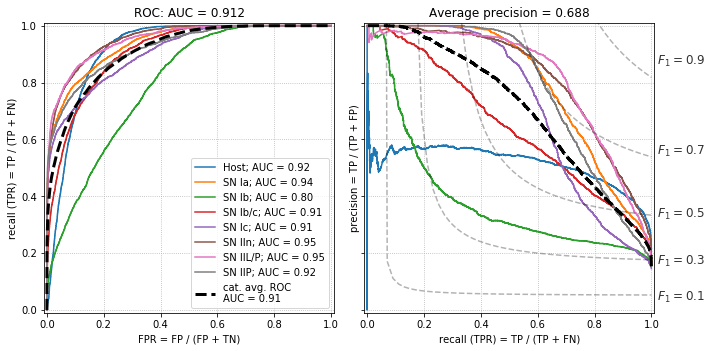

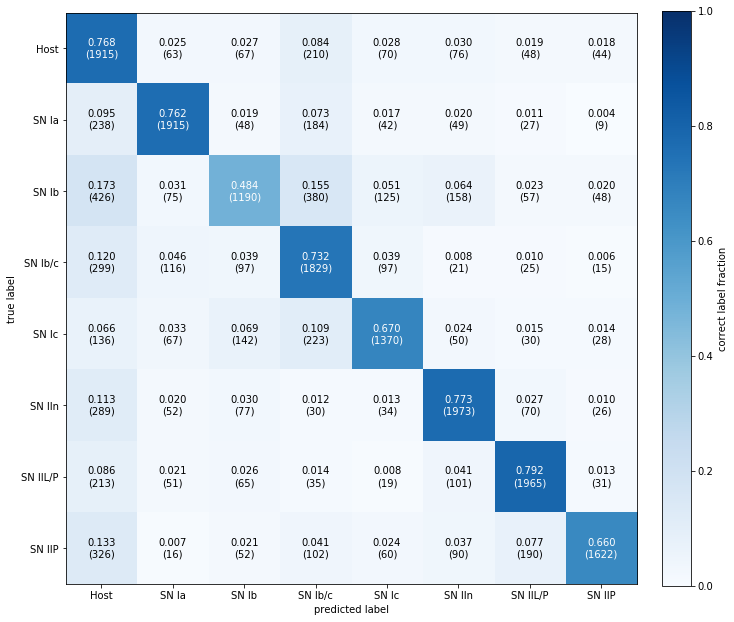

In [22]:
y_pred = model1.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

np.arange(cm.shape[1])

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

In [24]:
def network2(input_shape, ncat, learning_rate=.0002, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model2 = network2((nbins, 1),ncat=y.shape[1])


In [26]:
hist2 = model2.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 9s 162us/sample - loss: 2.4882 - acc: 0.4351 - val_loss: 1.9961 - val_acc: 0.5367
Epoch 2/50
58492/58492 [==============================] - 9s 148us/sample - loss: 1.7995 - acc: 0.5809 - val_loss: 1.6263 - val_acc: 0.6186
Epoch 3/50
58492/58492 [==============================] - 9s 148us/sample - loss: 1.5476 - acc: 0.6243 - val_loss: 1.4464 - val_acc: 0.6470
Epoch 4/50
58492/58492 [==============================] - 9s 149us/sample - loss: 1.3943 - acc: 0.6494 - val_loss: 1.3494 - val_acc: 0.6525
Epoch 5/50
58492/58492 [==============================] - 9s 149us/sample - loss: 1.2961 - acc: 0.6663 - val_loss: 1.2657 - val_acc: 0.6683
Epoch 6/50
58492/58492 [==============================] - 9s 149us/sample - loss: 1.2244 - acc: 0.6774 - val_loss: 1.2082 - val_acc: 0.6815
Epoch 7/50
58492/58492 [==============================] - 9s 149us/sample - loss: 1.1726 - acc: 0.6865 - val_l

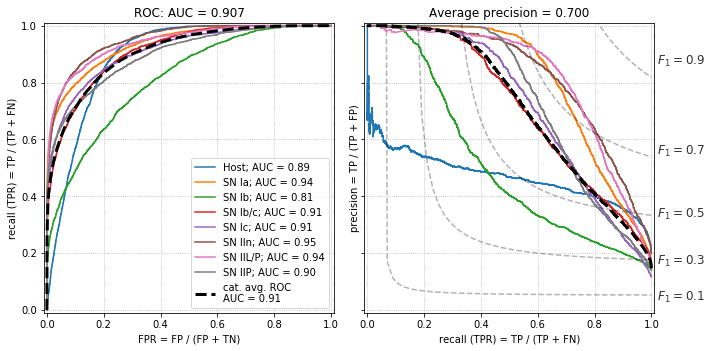

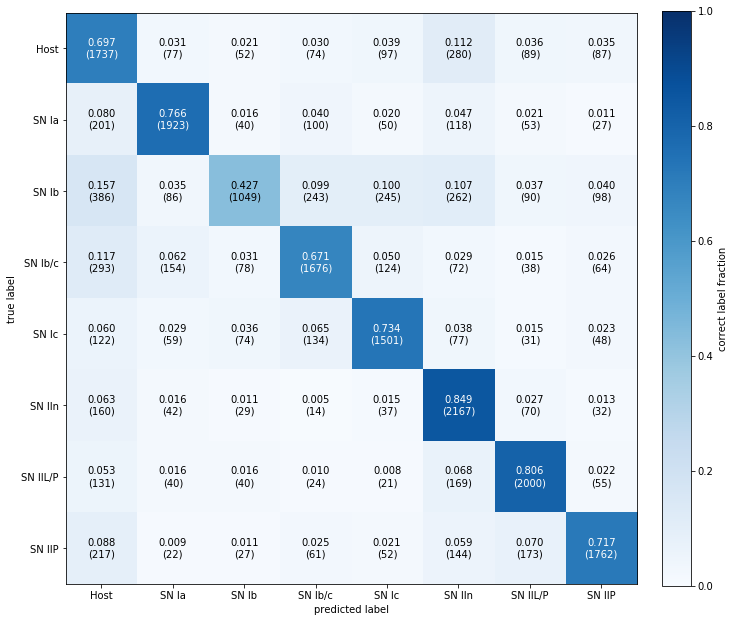

In [27]:
y_pred = model2.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

np.arange(cm.shape[1])

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

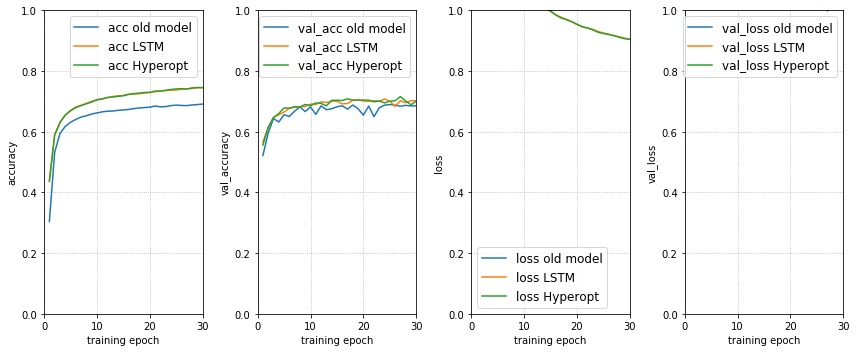

In [36]:
fig, axes = plt.subplots(1,4, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist1.history['acc'], label='acc old model')
ax.plot(epochs, hist.history['acc'], label='acc LSTM')
ax.plot(epochs, hist2.history['acc'], label='acc Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist1.history['val_acc'], label='val_acc old model')
ax.plot(epochs, hist.history['val_acc'], label='val_acc LSTM')
ax.plot(epochs, hist2.history['val_acc'], label='val_acc Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='val_accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[2]
ax.plot(epochs, hist1.history['loss'], label='loss old model')
ax.plot(epochs, hist.history['loss'], label='loss LSTM')
ax.plot(epochs, hist2.history['loss'], label='loss Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')


ax = axes[3]
ax.plot(epochs, hist1.history['val_loss'], label='val_loss old model')
ax.plot(epochs, hist.history['val_loss'], label='val_loss LSTM')
ax.plot(epochs, hist2.history['val_loss'], label='val_loss Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='val_loss',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')
fig.tight_layout();
fig.tight_layout();

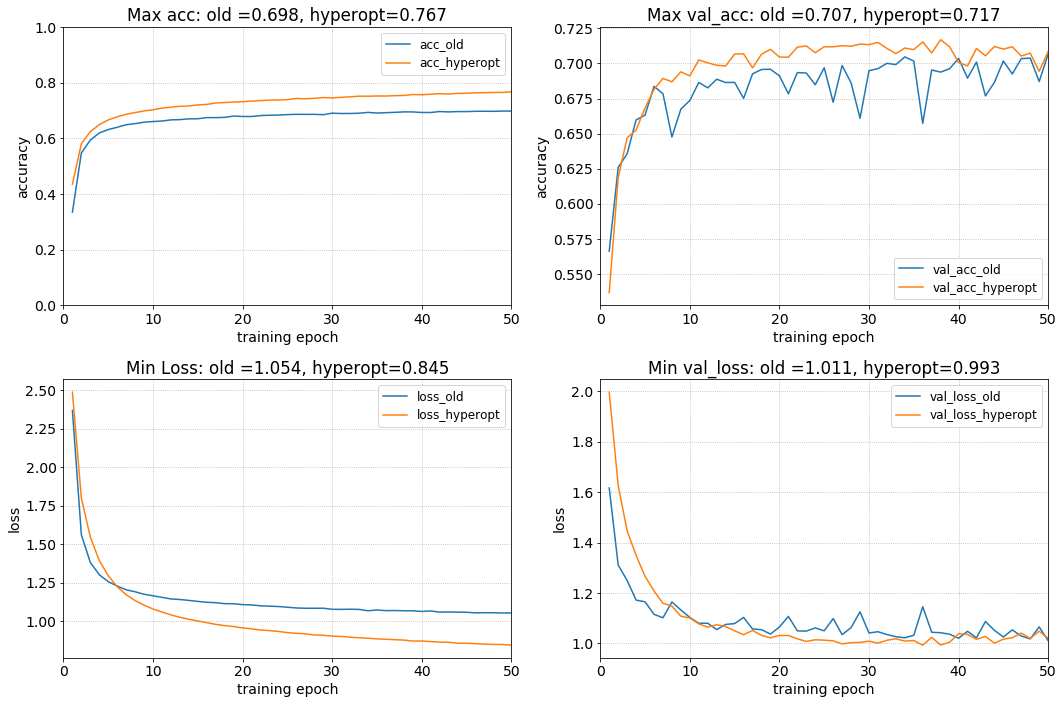

In [67]:
fig, ((axes[0],axes[1]),(axes[2],axes[3])) = plt.subplots(2,2, figsize=(15,10), sharex=False)

nepoch = len(hist1.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist1.history['acc'], label='acc_old')
ax.plot(epochs, hist2.history['acc'], label='acc_hyperopt')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0),
       title='Max acc: old ={0:0.3f}, hyperopt={1:0.3f}'.format(max(hist1.history['acc']),max(hist2.history['acc']))

      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')



ax = axes[1]
ax.plot(epochs, hist1.history['val_acc'], label='val_acc_old')
ax.plot(epochs, hist2.history['val_acc'], label='val_acc_hyperopt')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       title='Max val_acc: old ={0:0.3f}, hyperopt={1:0.3f}'.format(max(hist1.history['val_acc']),max(hist2.history['val_acc']))

#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')


ax = axes[2]
ax.plot(epochs, hist1.history['loss'], label='loss_old')
ax.plot(epochs, hist2.history['loss'], label='loss_hyperopt')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       title='Min Loss: old ={0:0.3f}, hyperopt={1:0.3f}'.format(min(hist1.history['loss']),min(hist2.history['loss']))

#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')



ax = axes[3]
ax.plot(epochs, hist1.history['val_loss'], label='val_loss_old')
ax.plot(epochs, hist2.history['val_loss'], label='val_loss_hyperopt')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       title='Min val_loss: old ={0:0.3f}, hyperopt={1:0.3f}'.format(min(hist1.history['val_loss']),min(hist2.history['val_loss']))

#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')



fig.tight_layout();

0.70668787